In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [22]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [23]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

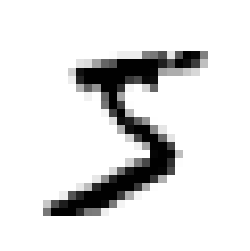

In [24]:
X=X.to_numpy()
y = y.astype(np.uint8)
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.figure(figsize=(3,3))
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [25]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [26]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

PART 1

In [ ]:
y_3_or_5 = (y == 3) | (y == 5)
X_3_or_5 = X[y_3_or_5]
y_3_or_5 = y[y_3_or_5]

y_train_3 = (y_3_or_5 == 3).astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_3_or_5, y_train_3, test_size=0.2, random_state=42)

sgd_clf = SGDClassifier(random_state=42)

accuracy_scores = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
print("Cross-validation accuracy scores:", accuracy_scores)

Cross-validation accuracy scores: [0.94481605 0.92084727 0.94507945]


In [29]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:\n", conf_matrix)

precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[4610  465]
 [ 214 5474]]
Precision: 0.9217039905708032
Recall: 0.9623769338959213
F1 Score: 0.9416014449127031


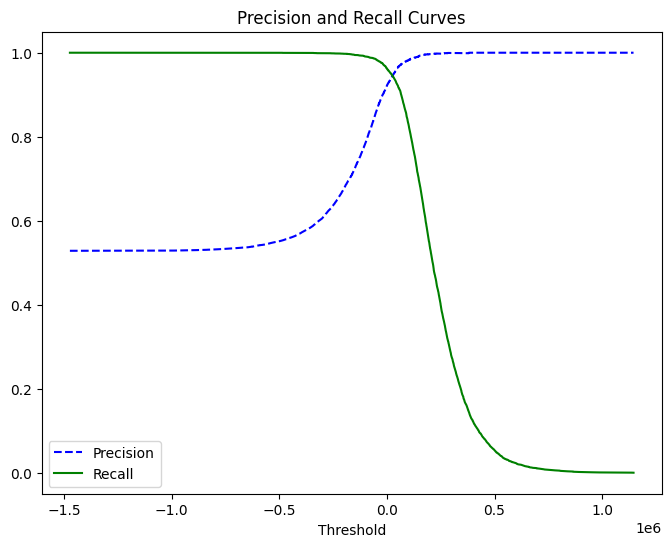

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.title("Precision and Recall Curves")
plt.show()

In [31]:
threshold = 0
y_train_pred_threshold = (y_scores > threshold).astype(int)

precision_threshold = precision_score(y_train, y_train_pred_threshold)
recall_threshold = recall_score(y_train, y_train_pred_threshold)

print("Precision at threshold:", precision_threshold)
print("Recall at threshold:", recall_threshold)

Precision at threshold: 0.9217039905708032
Recall at threshold: 0.9623769338959213


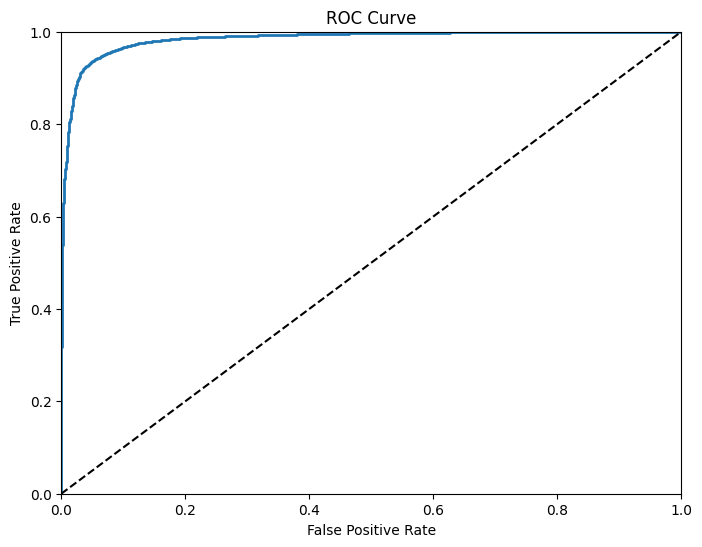

ROC AUC Score: 0.9843596405534424


In [32]:
fpr, tpr, roc_thresholds = roc_curve(y_train, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

roc_auc = roc_auc_score(y_train, y_scores)
print("ROC AUC Score:", roc_auc)

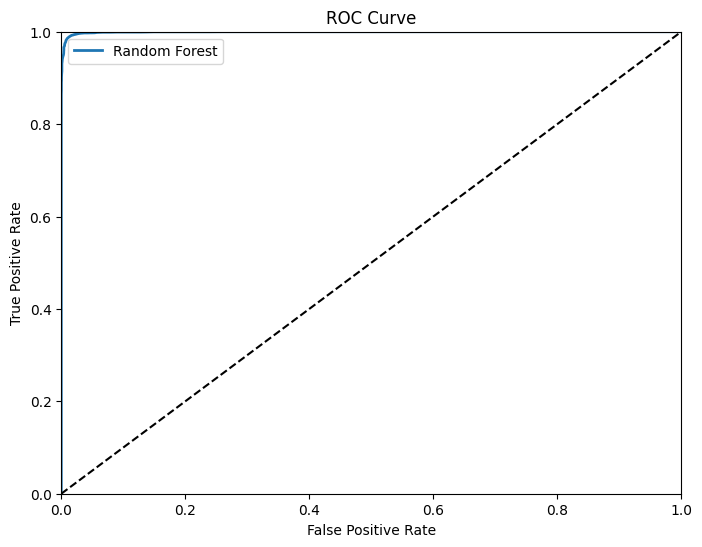

Random Forest ROC AUC Score: 0.9992887108284315


In [33]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, roc_thresholds_forest = roc_curve(y_train, y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

roc_auc_forest = roc_auc_score(y_train, y_scores_forest)
print("Random Forest ROC AUC Score:", roc_auc_forest)

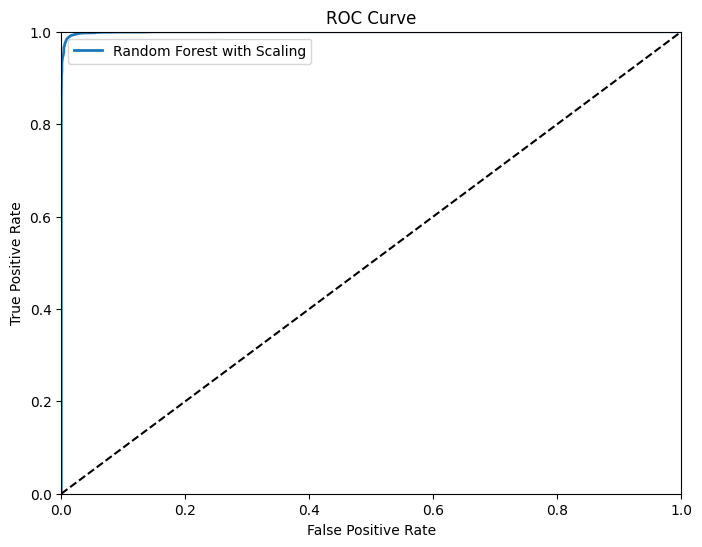

Random Forest with Scaling ROC AUC Score: 0.9992892131390603


In [34]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("forest_clf", RandomForestClassifier(random_state=42))
])

y_probas_forest_scaled = cross_val_predict(pipeline, X_train, y_train, cv=3, method="predict_proba")
y_scores_forest_scaled = y_probas_forest_scaled[:, 1]
fpr_forest_scaled, tpr_forest_scaled, roc_thresholds_forest_scaled = roc_curve(y_train, y_scores_forest_scaled)

plt.figure(figsize=(8, 6))
plt.plot(fpr_forest_scaled, tpr_forest_scaled, linewidth=2, label="Random Forest with Scaling")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

roc_auc_forest_scaled = roc_auc_score(y_train, y_scores_forest_scaled)
print("Random Forest with Scaling ROC AUC Score:", roc_auc_forest_scaled)

PART 2

In [35]:
y_3_or_5_or_others = (y == 3) | (y == 5)
X_3_or_5_or_others = X[y_3_or_5_or_others]
y_3_or_5_or_others = y[y_3_or_5_or_others]

X_train, X_test, y_train, y_test = train_test_split(X_3_or_5_or_others, y_3_or_5_or_others, test_size=0.2, random_state=42)

y_train_3_vs_5 = (y_train == 3).astype(int)
y_train_3_vs_others = (y_train == 3).astype(int)
y_train_5_vs_others = (y_train == 5).astype(int)

sgd_clf_3_vs_5 = SGDClassifier(random_state=42)
sgd_clf_3_vs_others = SGDClassifier(random_state=42)
sgd_clf_5_vs_others = SGDClassifier(random_state=42)

sgd_clf_3_vs_5.fit(X_train, y_train_3_vs_5)
sgd_clf_3_vs_others.fit(X_train, y_train_3_vs_others)
sgd_clf_5_vs_others.fit(X_train, y_train_5_vs_others)

def predict_multiclass(X):
    pred_3_vs_5 = sgd_clf_3_vs_5.predict(X)
    pred_3_vs_others = sgd_clf_3_vs_others.predict(X)
    pred_5_vs_others = sgd_clf_5_vs_others.predict(X)
    
    predictions = []
    for i in range(len(X)):
        wins = {3: 0, 5: 0, 'others': 0}
        
        if pred_3_vs_5[i] == 1:
            wins[3] += 1
        else:
            wins[5] += 1
        
        if pred_3_vs_others[i] == 1:
            wins[3] += 1
        else:
            wins['others'] += 1
        
        if pred_5_vs_others[i] == 1:
            wins[5] += 1
        else:
            wins['others'] += 1

        max_wins = max(wins.values())
        winning_classes = [k for k, v in wins.items() if v == max_wins]
        
        if len(winning_classes) == 1:
            predictions.append(winning_classes[0])
        else:
            predictions.append(np.random.choice(winning_classes))
    
    return np.array(predictions)

y_test_pred = predict_multiclass(X_test)

conf_matrix = confusion_matrix(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[1371   82]
 [  45 1193]]
Precision: 0.9532529767318877
Recall: 0.9528056484578223
F1 Score: 0.9528487595189601


PART 3

Best hyperparameters: {'n_neighbors': 5, 'weights': 'uniform'}
Test set accuracy: 0.989223337049424


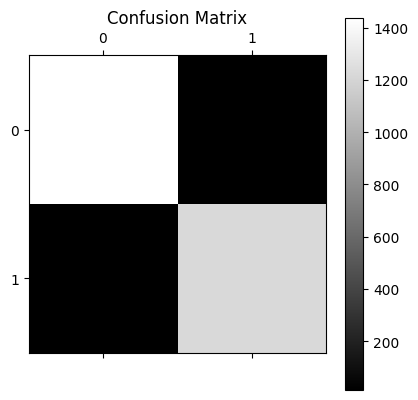

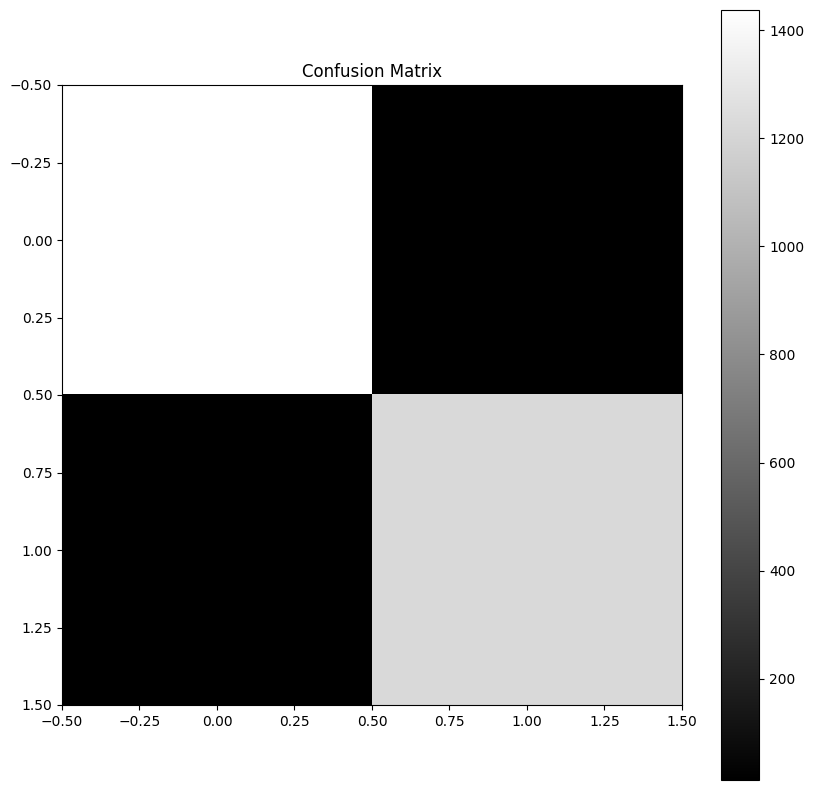

Confusion Matrix:
 [[1437   16]
 [  13 1225]]


In [36]:
param_grid = {
    'n_neighbors': [3, 4, 5],
    'weights': ['uniform', 'distance']
}
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

best_knn_clf = grid_search.best_estimator_
best_knn_clf.fit(X_train, y_train)

y_test_pred = best_knn_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, cmap=plt.cm.gray)
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

print("Confusion Matrix:\n", conf_matrix)

Digit Confusion: Some digits may be visually similar, leading to misclassifications (e.g., 3 vs 8, 5 vs 6).

Class Imbalance: If some classes have fewer samples, the model might perform worse on those classes.

Noise and Variability: Variations in handwriting can cause the model to misclassify certain digits.